# Simple plot for cross sections with z = constant

This notebook generates plot of z-constant sections. The imput data file name is  [sectio_prefix].[step #].[sectio_extention]

## Initial setup

In [1]:
import sys
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

from ctypes import *

Move current directory to directory with data to be averaged

In [2]:
%cd ./

/Volumes/Sources/matsui/Kemorin_MHD/MHD/pythons


Check if shared libraly to load is there

In [3]:
%ls -l "libcalypso_to_pythons.so"

-rwxr-xr-x  1 matsui  staff  782165 Jun 21 14:05 libcalypso_to_pythons.so*


Load dynamic library to run the program

In [4]:
libname = "libcalypso_to_pythons.so"
flib = cdll.LoadLibrary(libname)

## Go to data directory

Move current directory to directory with data to be averaged

In [5]:
cd ~/Desktop/sph_shell_197/psf

/Users/matsui/Desktop/sph_shell_197/psf


Check if data file to be averaged is there

In [6]:
ls -l

total 133588
-rw-r--r--  1 matsui  staff     4904 Jun 21 12:27 area_ave_psf_cmb.dat
-rw-r--r--  1 matsui  staff     4344 Jun 21 12:27 area_max_psf_cmb.dat
-rw-r--r--  1 matsui  staff     4344 Jun 21 12:27 area_min_psf_cmb.dat
-rw-r--r--  1 matsui  staff     4904 Jun 21 12:27 area_rms_psf_cmb.dat
-rw-r--r--  1 matsui  staff     4904 Jun 21 12:27 area_sdev_psf_cmb.dat
-rw-rw-r--  1 matsui  staff  1275536 Aug  8  2017 psf_cmb.0.grd.gz
-rw-rw-r--  1 matsui  staff  2350744 Jul 31  2017 psf_cmb.500.udt.gz
-rw-rw-r--  1 matsui  staff  2350796 Aug  1  2017 psf_cmb.501.udt.gz
-rw-rw-r--  1 matsui  staff  2350531 Aug  1  2017 psf_cmb.502.udt.gz
-rw-rw-r--  1 matsui  staff  2349980 Aug  1  2017 psf_cmb.503.udt.gz
-rw-rw-r--  1 matsui  staff  2348802 Aug  1  2017 psf_cmb.504.udt.gz
-rw-rw-r--  1 matsui  staff  2348498 Aug  1  2017 psf_cmb.505.udt.gz
-rw-rw-r--  1 matsui  staff  2349560 Aug  1  2017 psf_cmb.506.udt.gz
-rw-rw-r--  1 matsui  staff  2348557 Aug  1  2017 psf_cmb.507.udt.gz
-rw-rw-r--  

## Set file name to read and check the avaiable Gauss coefficient modes
The file name is defined by [file_name]. The beginning part of the data file [file_name] is read and listed field or component names to be stored.

In [7]:
file_name = "psf_z0.3.510.udt.gz"
# Check time range and modes in data file
flib.check_section_file_f.restype = c_int
flib.check_section_file_f.argtypes = [c_char_p]

istep_input = flib.check_section_file_f(file_name.encode())

 input_file_name: psf_z0.3.510.udt.gz
 prefix without step: psf_z0.3
 Firmat ID:           23
 Read step:          510


In [8]:
n_nod = np.zeros((1),dtype=np.int32)
n_ele = np.zeros((1),dtype=np.int32)
# Load time series of the Gauss coefficients
flib.load_section_file_f.restype = c_int
flib.load_section_file_f.argtypes = [c_int, np.ctypeslib.ndpointer(dtype=np.int32),
                                     np.ctypeslib.ndpointer(dtype=np.int32)]

ierr = flib.load_section_file_f(c_int(istep_input), n_nod, n_ele)
print("# of node and element: ", n_nod, n_ele)

# of node and element:  Index, # of componentns, field_name
           1           1 temperature
           2           3 velocity_cyl
           3           3 vorticity_cyl
           4           3 magnetic_field_cyl
           5           1 Lorentz_work
           6           1 buoyancy_flux
 [33120] [65664]


## Make a time evolution plot
The each time series data are expanded into each_series, and plotted into the line plot.
Please upgreade to more beautiful plot by yourself.

In [12]:
id_field = 1
id_comp =  1

x_psf =  np.zeros((n_nod),dtype=np.float64)
y_psf =  np.zeros((n_nod),dtype=np.float64)
ie_psf = np.zeros((3*n_ele),dtype=np.int32)
scalar_psf = np.zeros((n_nod),dtype=np.float64)


# Load patch data
flib.get_xy_section_patch_f.restype = c_int
flib.get_xy_section_patch_f.argtypes = [c_int, c_int, np.ctypeslib.ndpointer(dtype=np.float64),
                                        np.ctypeslib.ndpointer(dtype=np.float64), 
                                        np.ctypeslib.ndpointer(dtype=np.int32)]

ierr = flib.get_xy_section_patch_f(c_int(n_nod[0]), c_int(n_ele[0]), x_psf, y_psf, ie_psf)

# Load scalar data
flib.get_scalar_section_data_f.restype = c_int
flib.get_scalar_section_data_f.argtypes = [c_int, c_int, c_int,
                                     np.ctypeslib.ndpointer(dtype=np.float64)]

ierr = flib.get_scalar_section_data_f(c_int(n_nod[0]), c_int(id_field), c_int(id_comp), scalar_psf)


print(ie_psf.reshape(-1,3))

[[    1     6     0]
 [    0     6     5]
 [    2     7     1]
 ...
 [33117 31970 31969]
 [33119 31971 33118]
 [33118 31971 31970]]


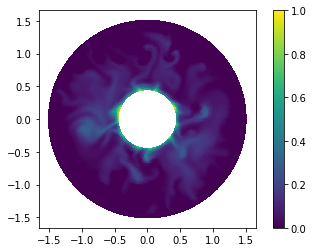

In [14]:
triang = mtri.Triangulation(x_psf, y_psf, ie_psf.reshape(-1,3))
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect('equal')
tpc = ax.tripcolor(triang, scalar_psf, vmin=-0, vmax=1, 
                   shading='flat')
fig.colorbar(tpc)

In [11]:
# Load time series of the Gauss coefficients
flib.finalize_section_data_f.restype = c_int
flib.finalize_section_data_f.argtypes = [c_int]

ierr = flib.finalize_section_data_f